#**1- Import Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

#**2- Reading Data**

##loading data

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

##check the data shape

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
y_train.shape

(60000,)

In [ ]:
x_test.shape

(10000, 28, 28)

In [ ]:
y_test.shape

(10000,)

#**3- Pre processing**

##Normalization

In [ ]:
x_train, x_test = x_train / 255., x_test / 255.

##reshape

In [ ]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

#**4- data augmentation**

##Noise function

In [ ]:
def add_noise(x):

    noisy_images = []
    for img in x:

        height, width = img.shape[:-1] # make the height = 28 and the width =28
        background = np.random.normal(loc=0.5, scale=0.2, size=(height, width, 1)) # give random number from the normal distrubtion loc is the mean and scale is the standard deviation
        blend_factor = 0.5  # is the blend factor which means how much I want to contribute the noise image and the clean image
        noisy_img_1 = np.clip(img * blend_factor + background * (1 - blend_factor), 0, 1) # we get the pixel in the image and multiple it by the blend factor and add the background to it so we can add grayscale background


        num_speckles = np.random.randint(20, 50) # give random numbers between 20-50
        speckled_img = noisy_img_1.copy()
        for x in range(num_speckles):
            x_co = np.random.randint(0, speckled_img.shape[0] - 2) #random number between 0 to shape -2 so it doesn't go out of range
            y_co = np.random.randint(0, speckled_img.shape[1] - 2)#random number between 0 to shape -2 so it doesn't go out of range
            speckled_img[x_co:x_co+2, y_co:y_co+2] = np.clip(speckled_img[x_co:x_co+2, y_co:y_co+2] + np.random.normal(scale=0.5, size=(2, 2, 1)), 0, 1) #clip is to make the value between 0,1 the first thing is to put added it to the pixel that we are in a random number



        line_start_y = 5 # the y that starts from
        line_end_y = 20 # the y that ends in
        line_intensity = 1 # the value of the pixel that I want to make the line

        x_coords = np.arange(width) # make an array from zero to width-1
        y_coords = np.linspace(line_start_y, line_end_y, num=width).astype(int) # give value between the line_start_y and the line_end_y with the same number of width to make sure it is the same
        y_coords = np.clip(y_coords, 0, height-1) # lower that y_coords is zero heighr than height-1 is height-1
        noisy_img_2 = speckled_img.copy()
        noisy_img_2[y_coords, x_coords] = line_intensity # it will move across the y_coords and x_coords and make them white so it will apper as a white line

        noisy_images.append(noisy_img_2)

    return np.array(noisy_images)

##noise train & test

In [ ]:
x_train_noisy = add_noise(x_train) # add noise to the x_train and store it in x_train_noisy
x_test_noisy = add_noise(x_test)  # add noise to the x_test and store it in x_test_noisy

#5- Build Autoencoder

##encoder

In [ ]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

##bottleneck

In [ ]:
encoded = MaxPooling2D((2, 2), padding='same')(x)

##decoder

In [ ]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

##compile

In [ ]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

##fitting and predict

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=15,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                verbose=2)

decoded_imgs = autoencoder.predict(x_test_noisy)

Epoch 1/15
469/469 - 120s - loss: 0.1741 - val_loss: 0.1187 - 120s/epoch - 256ms/step
Epoch 2/15
469/469 - 119s - loss: 0.1135 - val_loss: 0.1076 - 119s/epoch - 253ms/step
Epoch 3/15
469/469 - 120s - loss: 0.1064 - val_loss: 0.1039 - 120s/epoch - 256ms/step
Epoch 4/15
469/469 - 123s - loss: 0.1028 - val_loss: 0.1004 - 123s/epoch - 262ms/step
Epoch 5/15
469/469 - 119s - loss: 0.1003 - val_loss: 0.0992 - 119s/epoch - 254ms/step
Epoch 6/15
469/469 - 124s - loss: 0.0983 - val_loss: 0.0966 - 124s/epoch - 265ms/step
Epoch 7/15
469/469 - 120s - loss: 0.0969 - val_loss: 0.0955 - 120s/epoch - 257ms/step
Epoch 8/15
469/469 - 130s - loss: 0.0955 - val_loss: 0.0942 - 130s/epoch - 277ms/step
Epoch 9/15
469/469 - 120s - loss: 0.0941 - val_loss: 0.0930 - 120s/epoch - 256ms/step
Epoch 10/15
469/469 - 119s - loss: 0.0931 - val_loss: 0.0920 - 119s/epoch - 253ms/step
Epoch 11/15
469/469 - 120s - loss: 0.0922 - val_loss: 0.0912 - 120s/epoch - 257ms/step
Epoch 12/15
469/469 - 119s - loss: 0.0917 - val_loss

#5- visualize

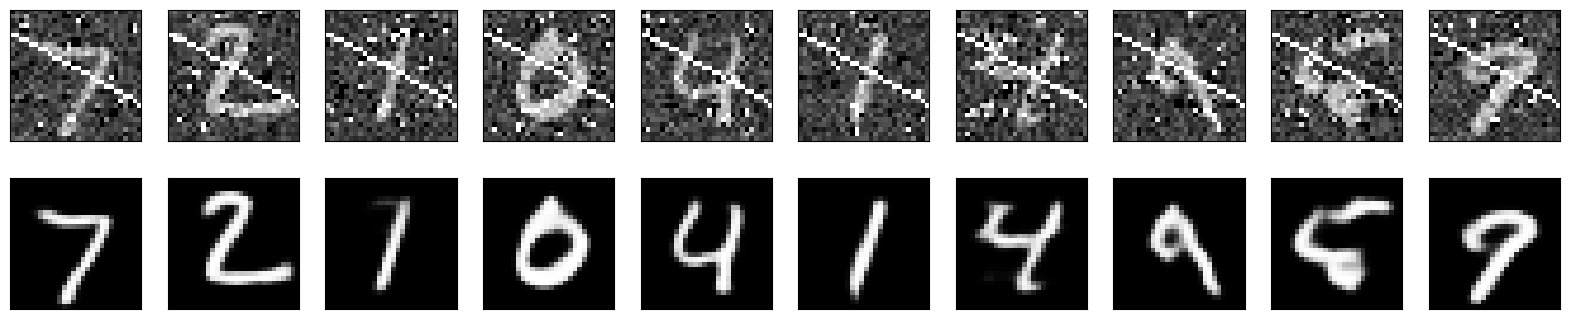

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()